<a href="https://colab.research.google.com/github/trevorVlong/underactuated/blob/main/fitted_double_integrator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='42d9bb576df2e323295c33eba90c4cb980f018a5', drake_version='0.25.0', drake_build='releases')

from IPython import get_ipython
import numpy as np
from time import sleep
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import meshcat
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pydrake.all import DiagramBuilder, LinearSystem, VectorSystem, Simulator, WrapToSystem, DiscreteAlgebraicRiccatiEquation
from pydrake.systems.controllers import (DynamicProgrammingOptions,
                                         FittedValueIteration, PeriodicBoundaryCondition)
from pydrake.systems.pyplot_visualizer import PyPlotVisualizer
from pydrake.systems.framework import Context, PortDataType


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import underactuated
from underactuated.double_integrator import DoubleIntegratorVisualizer
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend, running_as_notebook
from underactuated.meshcat_utils import plot_surface

plt_is_interactive = SetupMatplotlibBackend()

Cloning into '/opt/underactuated'...

HEAD is now at 42d9bb5 Updated fitted double integrator exercise






## Problem Description
In this problem we will be implementing the fitted value iteration algorithm and using it to solve the quadratic cost double integrator. While Drake provides an easy to use implementation of fitted value iteration, here we will be using a neural net to approximate the cost-to-go function instead. We will then use our cost-to-go function approximation to generate a control policy. 

**These are the main steps of the notebook:**
1. Implement the neural network in order to approximate the cost-to-go function.
2. Write the target network update in the training loop.
3. Extract the policy from the cost-to-go function estimate.
4. Answer the written questions at the bottom and submit them to Gradescope as a .pdf file.

Note that in order to pass the autograder, you do not need to tune any hyperparameters! This includes random seeds, learning rate, training iterations, and initializations. Feel free to play around with these, but set them to the original values when you want to test with the autograder.

In [2]:
def set_seed(seed=0):
  np.random.seed(seed)
  torch.random.manual_seed(seed)

## Defining our Cost Function Approximator

In order to perform value iteration in a continuous state space, we will use a neural network to approximate the cost-to-go $J(x)$. Our network will take as input the double integrator state $x = [q, \dot q]$, and output $J(x)$. Implement the following architecture:

- Linear layer with 2 inputs, 120 outputs
- Leaky relu nonlinearity
- Linear layer with 120 inputs, 84 outputs
- Leaky relu nonlinearity
- Linear layer with 84 inputs, 1 ouput

An example placeholder layer is implemented for you, and we show you how to call it functionally in `forward` with a leaky relu nonlinearity. This is an alternative way to define a network instead of stacking layers using `nn.Sequential`. Try it out!


In [3]:
# Define the function approximator for J
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        ### TODO ###
        self.fc1 = nn.Linear(2, 120) # placeholder
        self.fc2 = nn.Linear(120, 84) # placeholder
        self.fc3 = nn.Linear(84, 1) # placeholder


    def forward(self, x):
        ### TODO ###
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        J = F.leaky_relu(self.fc3(x))
        return J

## Defining the state-space and cost function

Below we define two costs. We have the quadratic regulator cost:

$$g(x, u) = x^T Q x + u^T R u$$

And we have the minimum time cost:

$$g(x) = 1 \text{  if  } x = 0, \text{  else  } 0$$

These will both seek to stabilize the system to the origin $x = 0$. The solution to the quadratic regulator cost makes use of drake to generate to solve the algebraic riccati equation and generate the solution matrix $S$.


In [4]:
Q = torch.eye(2)
R = torch.eye(1)
def quadratic_regulator_cost(xt, ut):
    return xt.matmul(Q.matmul(xt.transpose(-2,-1))) + ut.matmul(R.matmul(ut.transpose(-2,-1)))

def quadratic_regulator_solution(xt, timestep):
  S = DiscreteAlgebraicRiccatiEquation(A=(np.eye(2)+timestep*A.numpy()),
                                       B=timestep*B.numpy(),
                                       Q=Q, R=R)
  return xt.matmul(torch.from_numpy(S).float().matmul(xt.transpose(-2,-1)))

# Define the cost function
def min_time_cost(xt):
    at_goal = torch.isclose(xt, torch.zeros(1,2), atol=1e-3)
    # cost = 1 if ~at_goal * [1;1] >= 1, 0 otherwise.
    return torch.min((~at_goal).float().matmul(torch.ones(2,1)), torch.ones(1))

def min_time_solution(xt):
  # Caveat: this does not take the time discretization (zero-order hold on u) into account.
  q = xt[:,:,0]
  qdot = xt[:,:,1]
  # mask indicates that we are in the regime where u = +1.
  mask = ((qdot < 0) & (2*q <= qdot.pow(2))) | ((qdot >= 0) & (2*q < -qdot.pow(2)))
  T = torch.empty(q.size())
  T[mask] = 2*(.5*(qdot[mask].pow(2)) - q[mask]).sqrt() - qdot[mask]
  T[~mask] = qdot[~mask] + 2*(.5*(qdot[~mask].pow(2)) + q[~mask]).sqrt()
  return T.unsqueeze(-1)

In the cell below, we set the state space samples we will use to train the network, the action space discretization, and the timestep increment. We produce a mesh over state space, and for each state in this mesh we produce the cost $g(x, u)$ and the next state for each action taken. Because the double integrator is a linear system, generating the next states can be done very simply using the coefficient matrices $A$ and $B$! There is also a method below that we will use to plot the estimated cost surface produced by our neural net, and plot the analytical cost surface. Feel free to take a look if you're interested. 

In [5]:
# Define state-space and timestep increment, and cost type
num_x1s = 31
num_x2s = 51
num_states = num_x1s*num_x2s
num_actions = 9
x1s = torch.linspace(-3,3,num_x1s)
x2s = torch.linspace(-3,3,num_x2s)
us = torch.linspace(-1,1,num_actions)
timestep = 0.1

# Define batch of states with actions
X1s, X2s = torch.meshgrid(x1s, x2s)
X = torch.stack((X1s.flatten(), X2s.flatten()), 1).unsqueeze(1)
X1s_wU, X2s_wU, Us_wX = torch.meshgrid(x1s, x2s, us)
XwithU = torch.stack((X1s_wU.flatten(0,1), X2s_wU.flatten(0,1)), 2).unsqueeze(2)
UwithX = Us_wX.flatten(0,1).unsqueeze(-1).unsqueeze(-1)

# Define coefficient matrices for double integrator state-space representation
A = torch.tensor([[0., 1.], [0., 0.]])
B = torch.tensor([[0.], [1.]])
At = A.transpose(0, 1)
Bt = B.transpose(0, 1)

# Generate next states and costs
Xnext = XwithU + timestep * (XwithU.matmul(At) + UwithX.matmul(Bt))
G_quadratic = timestep*quadratic_regulator_cost(XwithU, UwithX)
G_min_time = timestep*min_time_cost(XwithU)

In [6]:
def plot_and_compare(net, timestep, min_time=False):

  with torch.no_grad():
    J = net.forward(X)

  # Plot estimated cost surface
  fig = plt.figure(figsize=(9, 4))
  ax1, ax2 = fig.subplots(1, 2, subplot_kw=dict(projection='3d'))
  ax1.set_xlabel("q")
  ax1.set_ylabel("qdot")
  ax1.set_title("Estimated Cost-to-Go")
  ax1.plot_surface(X1s, X2s, J.view(X1s.size()).detach().numpy(), rstride=1, cstride=1, cmap=cm.jet)
  
  # Plot analytical cost surface
  if min_time:
    Jd = min_time_solution(X)
  else:
    Jd = quadratic_regulator_solution(X, timestep)
  ax2.set_xlabel("q")
  ax2.set_ylabel("qdot")
  ax2.set_title("Analytical Cost-to-Go")
  ax2.plot_surface(X1s, X2s, Jd.view(X1s.size()).detach().numpy(), rstride=1, cstride=1, cmap=cm.jet)
    
  # Score is worst absolute different (e.g. infinity-norm) of the samples
  criterion = nn.MSELoss()
  score = criterion(J, Jd).item()


## Fitting the Cost-to-go Function

We can now fit the cost-to-go function. The idea is to train a single neural network to approximate the cost-to-go function, and use a target network to represent our "latest cost-to-go function estimate". In the `solve` method below, write one line of code that takes the weights from `net` and loads them into `target_net` before computing the targets. You can access the state of a networks weights using `net.state_dict()`. This is useful for saving files with your model weights (see [saving in pytorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html)). Weights can be loaded into a model using `net.load_state_dict()`. 

In [7]:
def solve(net, target_net, loss_function, optimizer, discount, min_time=False):

  if min_time:
    G = G_min_time
  else:
    G = G_quadratic
  
  final_loss = 0.0
  for epoch in range(2000):
    net.zero_grad()

    ### TODO ###
    # Update the target network with the previous weights from net
    target_net.load_state_dict(net.state_dict())
    ############

    with torch.no_grad():
      Jnext = target_net.forward(Xnext)
      Jd, ind = torch.min(G + discount*Jnext, dim=1) # we discount the future cost-to-go
    J = net.forward(X)
    loss = loss_function(J, Jd)
    loss.backward()
    optimizer.step()

    if epoch % 199 == 0:
      plot_and_compare(net, timestep, min_time=min_time)

  final_loss = loss.item()
  return net, final_loss

## Training the Networks

Now that we defined the training loop, we can train our models! Feel free to play with the hyperparameters and the seed. 

**For the autograder to work, change the two cells below back to their original state.**

Final loss:  0.002972301794216037


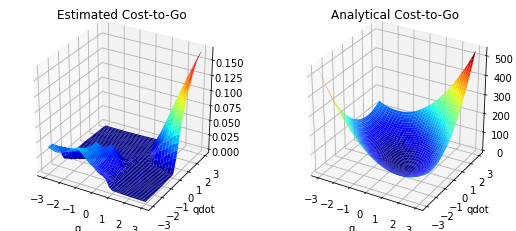

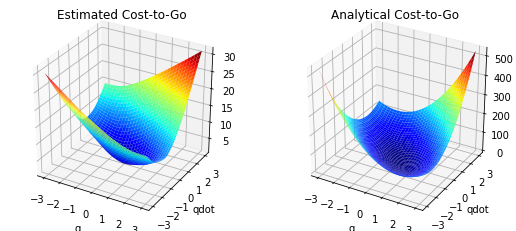

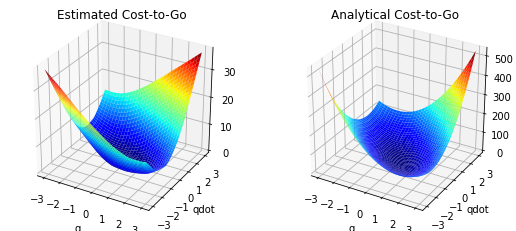

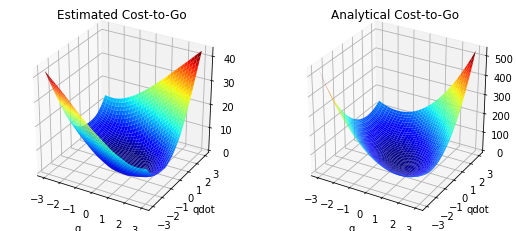

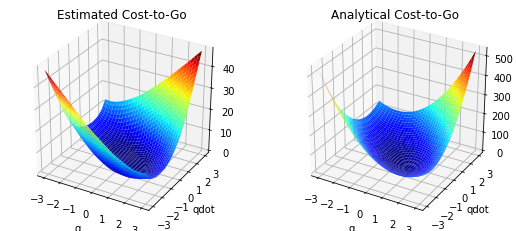

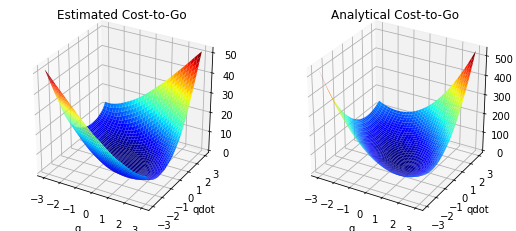

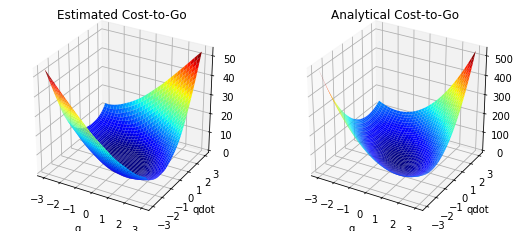

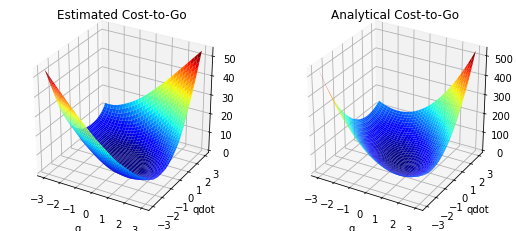

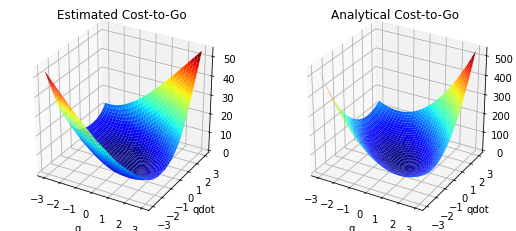

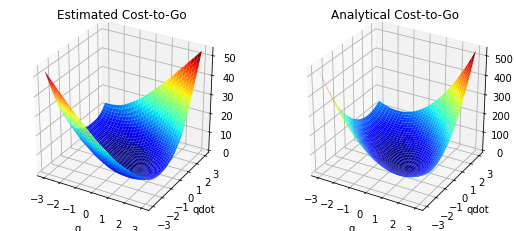

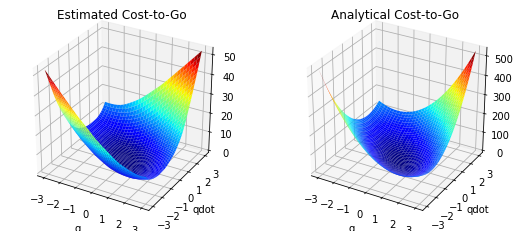

In [8]:
# For the autograder to work, you do not need to modify this cell!
set_seed(12345)
net_quadratic = Net()
target_net_quadratic = Net()
loss_function = nn.MSELoss()
optimizer = optim.SGD(net_quadratic.parameters(), lr=0.01)
gamma_quadratic = 0.95 # discount factor
net_quadratic, final_loss_quadratic = solve(net_quadratic, target_net_quadratic, loss_function, optimizer, gamma_quadratic, min_time=False)
print("Final loss: ", final_loss_quadratic)

Final loss:  0.00011612117668846622


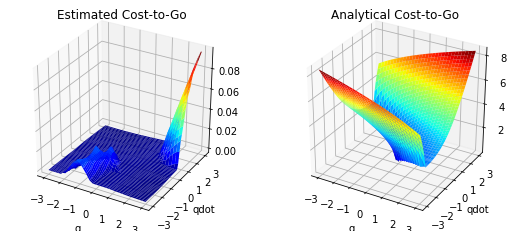

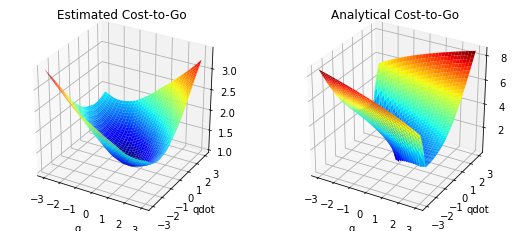

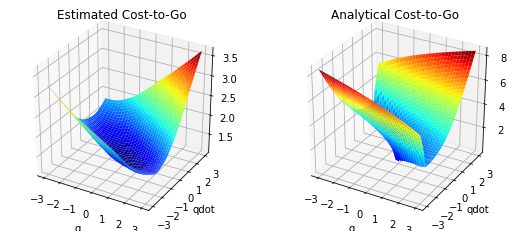

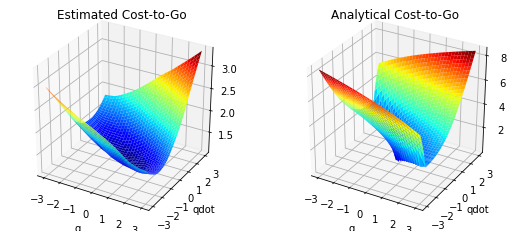

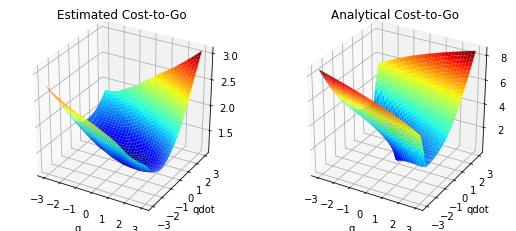

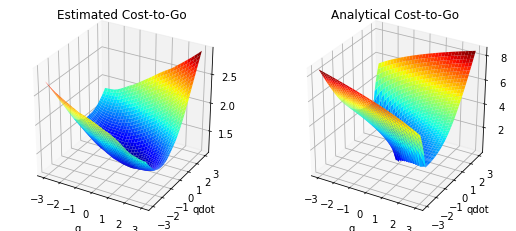

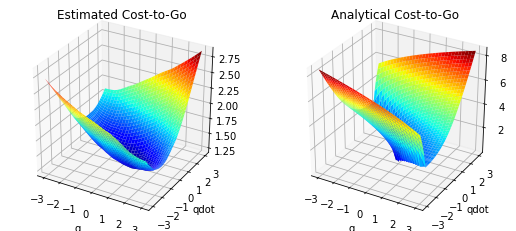

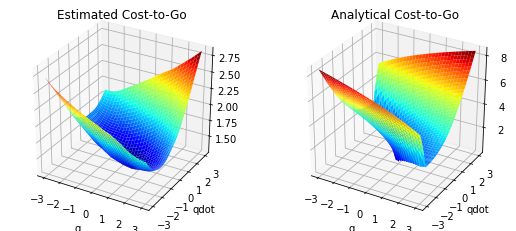

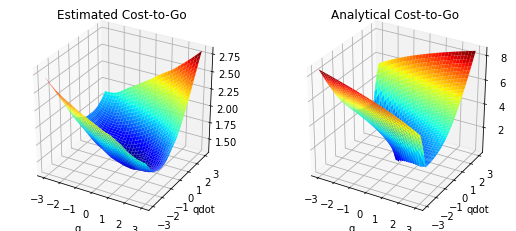

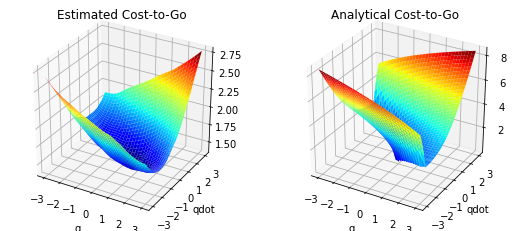

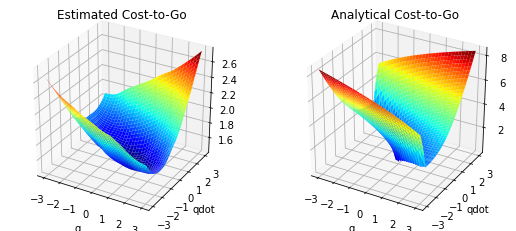

In [9]:
# For the autograder to work, you do not need to modify this cell!
set_seed(12345)
net_min_time = Net()
target_net_min_time = Net()
loss_function = nn.MSELoss()
optimizer = optim.SGD(net_min_time.parameters(), lr=0.0015, momentum=0.9)
gamma_min_time = 0.95 # discount factor
net_min_time, final_loss_min_time = solve(net_min_time, target_net_min_time, loss_function, optimizer, gamma_min_time, min_time=True)
print("Final loss: ", final_loss_min_time)

## Extracting the Policy

Remember that the cost-to-go implicitly encodes our policy - if we can score every state, we should know exactly where we want to go! Now that we trained a neural network to approximate the cost-to-go $J(x)$, we should be able to use this approximation to extract a policy and control our system. In the cell below, your job is to fill in the code in the `DoCalcVectorOutput` method where we have marked `### TODO ###`. Update the value of `torque` with the best action given the `state`.

In [418]:
class Policy(VectorSystem):

    def __init__(self, net, gamma, us, min_time=False):
        # 2 inputs: double integrator state [q, q_dot]
        # 1 output: control torque [u]
        VectorSystem.__init__(self, 2,  1)
        self.net = net
        self.gamma = gamma
        self.us = us # torch tensor with all possible actions
        self.min_time = min_time
        if min_time:
          is_close = lambda x: np.isclose(x, [0., 0.]).astype(float)
          self.cost = lambda x, u: 0.0 if np.dot(is_close(x), is_close(x).T) == 2.0 else 1.0
        else:
          self.cost = lambda x, u: np.dot(x, x.T) + u**2
        self.timestep=0.1

    def DoCalcVectorOutput(self, context, state, unused, torque):
        ### TODO ###
        # Find the best torque
        # Note: this method doesn't return anything, it just updates 'torque'
# don't need context or unused to solve this, picked up by drake
        # torque[:] = 0

        # dxnext = state[1] + self.us * self.timestep
        # dxnext = dxnext.numpy()
        # xnext = state[0] + state[1]*self.timestep
        # nextstate = [torch.tensor([xnext, dx]) for dx in dxnext]
        
        # Js = [[self.net.forward(si.float())] for si in nextstate]
        # l  = torch.tensor(self.cost(state,self.us))
        # print('Js')
        # print(Js)
        # print('l')
        # print(l)
        # total_cost = [[Ji[0].add(l)] for Ji in Js]

        total_cost = []
        for ui in self.us:
          dxnext = state[1] + ui * self.timestep
          dxnext = dxnext.numpy()
          xnext = state[0] + state[1]*self.timestep
          nextstate = torch.tensor([xnext,dxnext])
          Js = self.net.forward(nextstate.float())
          l = torch.tensor(self.cost(state,ui))
          total_cost.append(Js.add(l))


        # total_cost = Js.add(l)
        # type(l)


        # print('here')
        # print(total_cost)
        torque[:] = self.us[np.argmin(total_cost)]

       

        ############

## Simulating the System

In the cell below we've plugged our policy into a drake diagram. We simulate the minimum time cost policy, and the quadratic regulator cost policy. There is nothing to implement here, but this is another opportunity to familiarize yourselves with drake so definitely take a look!

The basic workflow involves instantiating a drake `diagram`, and adding `systems` to it. Systems can be pre-defined in drake (like the visualizer we use below for the double integrator), or we can define them ourselves (like the double integrator plant we define as a custom `LinearSystem`, or the policy which we implemented as a `VectorSystem` above). Once systems are added, we can connect their inputs and outputs to other systems to dictate the flow of information within the diagram. Lastly, we pass our diagram to `simulator` which will simulate and visualize the evolution of our overall system in time. 

Feel free to play with the starting state, and the simulation duration.

**For the autograder to work, change back to the original starting state ([3., 3.]) and the original simulation duration (25)!**

In [419]:
def simulate_policy(minimum_time=False):
  # Feel free to try different starting states
  start_state = [3., 3.] # set to [3, 3] for the autograder!

  # Instantiate the policy system
  if minimum_time:
    net_min_time.eval()
    policy = Policy(net_min_time, gamma_min_time, us, min_time=True)
  else:
    net_quadratic.eval()
    policy = Policy(net_quadratic, gamma_quadratic, us, min_time=False)

  # Wire up the drake diagram
  double_integrator_plant = LinearSystem(A=np.mat('0 1; 0 0'),
                                         B=np.mat('0; 1'),
                                         C=np.eye(2),
                                         D=np.zeros((2,1)))
  builder = DiagramBuilder() # instantiate a diagram builder
  plant = builder.AddSystem(double_integrator_plant) # add a sub-system to it
  vi_policy = builder.AddSystem(policy)
  builder.Connect(plant.get_output_port(0), vi_policy.get_input_port(0)) # connecting inputs/outputs of two sub-systems in our diagram
  builder.Connect(vi_policy.get_output_port(0), plant.get_input_port(0))
  visualizer = builder.AddSystem(DoubleIntegratorVisualizer(show=plt_is_interactive))
  builder.Connect(plant.get_output_port(0), visualizer.get_input_port(0))
  diagram = builder.Build() # finish building the diagram

  # Simulate the system
  simulator = Simulator(diagram)
  simulator.get_mutable_context().SetContinuousState(start_state) # set the initial state
  AdvanceToAndVisualize(simulator, visualizer, 25.)

  return simulator.get_mutable_context().get_continuous_state()

In [420]:
# Simulate the minimum time policy
final_state_min_time = simulate_policy(minimum_time=True)
print("Final State: ", final_state_min_time[0], final_state_min_time[1])

simulating...  done.
generating animation...


Final State:  0.5091409201632792 0.0059237568068067


In [421]:
# Simulate the quadratic cost policy
final_state_quadratic = simulate_policy(minimum_time=False)
print("Final State: ", final_state_quadratic[0], final_state_quadratic[1])

simulating...  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


done.
generating animation...


Final State:  -0.07134388648916798 0.4104853044929635


## Written Questions

1) Work through the coding sections in this notebook.

2) Although it gets close, why does the system not stabilize exactly at the origin?

3) In the notebook we implemented "fitted value iteration".  In the questions below, you'll be asked to think about the differences between the "graph search" version of value iteration we saw at the start of chapter 7, and fitted value iteration. Answer the questions below with a brief explanation:

*   Can graph search value iteration perform in a continuous state space? Can fitted value iteration?
*   Can graph search value iteration perform with very large discrete action spaces, or continuous action spaces? Can fitted value iteration?

4) For our implementation, we assume deterministic transitions between states. This means that given a particular state $x_t$ and action $u_t$, we will always end up in the same unique $x_{t+1}$. Mathematically:

$$x_{t+1} = f(x_t, u_t)$$

In real world scenarios we often have to deal with disturbances or dynamics not captured by our model, which can cause our state transitions to be stochastic. Mathematically:

$$P(x_{t+1} | x_t, u_t) = f(x_t, u_t)$$

If we had stochastic transitions, which steps of the notebook implementation would need to change, and how would they change? The possible steps to choose from are listed below - you can select multiple. When describing the change, a verbal description is fine you do not need to include any code:

* Sampling the set of points <code>X</code> before performing the fit.
* Generating the costs <code>G</code> before performing the fit.
* Updating the cost function target in the training loop: <code>Jd, ind = torch.min(G + discount*Jnext, dim=1)</code>.
* Choosing the best torque when simulating the system.


## Autograding
The autograder has two tests:

1) Test that the final loss generated for both the quadratic cost and the minimum time cost is within some range.

2) Test that the generated policies land the system within the right final state range after simulation. 

You can check your work by running the following cell:

In [422]:
from underactuated.exercises.dp.fitted_double_integrator.test_fitted_double_integrator import TestFittedDoubleIntegrator
from underactuated.exercises.grader import Grader
Grader.grade_output([TestFittedDoubleIntegrator], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 4/4.

Score for Test model training is 2/2.

Score for Test closed form policy is 2/2.
